## 1. Build Regression Model with TF DenseFeatures

### Overview
- Used preprocessed dataset from TF regression tutorial https://www.tensorflow.org/tutorials/keras/regression
- Used TF feature column API and TF DenseFeatures instead of the methods used in tutorial

### Dataset Preprocessing From Tutorial

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [2]:
dataset_path = tf.keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")

32768/30286 [================================] - 0s 1us/step


In [3]:
# Data is read in across different files
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)
raw_dataset.columns = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'ModelYear', 'Origin']
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,ModelYear,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [60]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
ModelYear       0
Origin          0
dtype: int64

In [61]:
dataset = dataset.dropna()

In [62]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [7]:
#split 80 20 train test split
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [8]:
train_dataset.columns

Index(['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
       'Acceleration', 'ModelYear', 'Origin'],
      dtype='object')

In [9]:
train_dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,ModelYear,Origin
146,28.0,4,90.0,75.0,2125.0,14.5,74,USA
282,22.3,4,140.0,88.0,2890.0,17.3,79,USA
69,12.0,8,350.0,160.0,4456.0,13.5,72,USA
378,38.0,4,105.0,63.0,2125.0,14.7,82,USA
331,33.8,4,97.0,67.0,2145.0,18.0,80,Japan


In [10]:
train_labels = train_dataset['MPG']

In [11]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
ModelYear,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0


In [12]:
# Identify categorical and numerical features

categorical_feature_list = ['Origin']
# for the sake of this exercise treat Model Year and Cylinders as numerical but could process differently
numerical_feature_list = ['Cylinders', 'Displacement', 'Horsepower', 'Weight',
       'Acceleration', 'ModelYear']

In [13]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset[numerical_feature_list])
normed_test_data = norm(test_dataset[numerical_feature_list])

In [14]:
norm_train_data = pd.concat([ train_dataset[categorical_feature_list + ['MPG']],  normed_train_data], 
                            axis=1, sort=False)
norm_test_data = pd.concat([ test_dataset[categorical_feature_list + ['MPG']], normed_test_data], axis=1, sort=False)

In [15]:
norm_train_data.to_csv("mpg_train_data.csv", index=False)
norm_test_data.to_csv("mpg_test_data.csv", index=False)

In [16]:
norm_train_data.head()

,Origin,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,ModelYear
146,USA,28.0,-0.869348,-1.009459,-0.784052,-1.025303,-0.379759,-0.516397
282,USA,22.3,-0.869348,-0.530218,-0.442811,-0.118796,0.624102,0.843910
69,USA,12.0,1.483887,1.482595,1.447140,1.736877,-0.738281,-1.060519
378,USA,38.0,-0.869348,-0.865687,-1.099044,-1.025303,-0.308055,1.660094
331,Japan,33.8,-0.869348,-0.942365,-0.994047,-1.001603,0.875068,1.115971


### Load Preprocessed Dataset

- Use TF Dataset API and Feature Column APIs instead

In [17]:
# Mile stone -- read the preprocessed data in, and start the process of TF preprocessing
train_data = pd.read_csv("mpg_train_data.csv" )
test_data = pd.read_csv("mpg_test_data.csv" )

In [18]:
#adapted from https://www.tensorflow.org/tutorials/structured_data/feature_columns

# Always feels too manual to make these batches...
def df_to_dataset(df, predictor,  batch_size=32):
    df = df.copy()
    labels = df.pop(predictor)
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    ds = ds.shuffle(buffer_size=len(df))
    ds = ds.batch(batch_size)
    return ds

In [63]:
# Convert to tensors, acknowledging the label as well as the batch size.

PREDICTOR_FIELD = 'MPG'
batch_size = 128
train_ds = df_to_dataset(train_data, PREDICTOR_FIELD, batch_size=batch_size)
test_ds = df_to_dataset(test_data, PREDICTOR_FIELD, batch_size=batch_size)

In [64]:
sample_batch = next(iter(train_ds))[0]
def demo(feature_column, example_batch):
    feature_layer = tf.keras.layers.DenseFeatures(feature_column)
    print(feature_layer(example_batch))

### Convert Origin Categorical Feature to One Hot Encoded Feature

In [21]:
# only feature 
v_list = tf.feature_column.categorical_column_with_vocabulary_list("Origin", 
                                                            train_data['Origin'].unique())
one_hot_origin_feature = tf.feature_column.indicator_column(v_list)

In [22]:
print("Example categorical field:\n{}".format(one_hot_origin_feature))
demo(one_hot_origin_feature, sample_batch)

Example categorical field:
IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='Origin', vocabulary_list=('USA', 'Japan', 'Europe'), dtype=tf.string, default_value=-1, num_oov_buckets=0))
tf.Tensor(
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [

### Create Numerical Features

NOTE: We do not use the normalizer function here because the dataset has already been normalized.

In [23]:
#convert numerical features, these features have already been normalized
def create_tf_numerical_feature_cols(numerical_col_list):
    tf_numeric_col_list = []
    for c in numerical_col_list:
        tf_numeric_feature = tf.feature_column.numeric_column(
                    key=c,  dtype=tf.float64)
        tf_numeric_col_list.append(tf_numeric_feature)
    return tf_numeric_col_list

In [24]:
# Basically just identify our numerical features within our tensor
tf_numerical_feature_list = create_tf_numerical_feature_cols(numerical_feature_list)

In [25]:
tf_numerical_feature_list

[NumericColumn(key='Cylinders', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None),
 NumericColumn(key='Displacement', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None),
 NumericColumn(key='Horsepower', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None),
 NumericColumn(key='Weight', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None),
 NumericColumn(key='Acceleration', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None),
 NumericColumn(key='ModelYear', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None)]

In [26]:
# take first numerical feature
test_cont_var1 = tf_numerical_feature_list[0]
print("Example continuous field:\n{}\n".format(test_cont_var1))
demo(test_cont_var1, sample_batch)

Example continuous field:
NumericColumn(key='Cylinders', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None)

tf.Tensor(
[[ 1.4838872 ]
 [ 1.4838872 ]
 [ 1.4838872 ]
 [ 0.30726957]
 [-0.86934805]
 [ 0.30726957]
 [-0.86934805]
 [ 1.4838872 ]
 [-0.86934805]
 [ 0.30726957]
 [-0.86934805]
 [-0.86934805]
 [ 0.30726957]
 [ 1.4838872 ]
 [-0.28103924]
 [ 0.30726957]
 [ 1.4838872 ]
 [-0.86934805]
 [-0.86934805]
 [-0.86934805]
 [ 1.4838872 ]
 [ 1.4838872 ]
 [ 1.4838872 ]
 [ 1.4838872 ]
 [-0.86934805]
 [-0.86934805]
 [ 0.30726957]
 [ 1.4838872 ]
 [-0.86934805]
 [-0.86934805]
 [ 0.30726957]
 [ 0.30726957]
 [-0.86934805]
 [-0.86934805]
 [-0.86934805]
 [ 1.4838872 ]
 [-0.86934805]
 [-0.86934805]
 [-0.86934805]
 [ 0.30726957]
 [-0.86934805]
 [ 0.30726957]
 [ 1.4838872 ]
 [-0.86934805]
 [-0.86934805]
 [ 1.4838872 ]
 [ 1.4838872 ]
 [ 1.4838872 ]
 [-0.86934805]
 [-0.86934805]
 [-0.86934805]
 [ 1.4838872 ]
 [-0.86934805]
 [-0.86934805]
 [ 0.30726957]
 [-0.86934805]
 [-0.86934805]
 [ 1.4

### Combine TF Features with DenseFeatures

In [27]:
# Combine all of our features
feature_columns = [ one_hot_origin_feature ] + tf_numerical_feature_list

In [28]:
feature_columns

[IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='Origin', vocabulary_list=('USA', 'Japan', 'Europe'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 NumericColumn(key='Cylinders', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None),
 NumericColumn(key='Displacement', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None),
 NumericColumn(key='Horsepower', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None),
 NumericColumn(key='Weight', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None),
 NumericColumn(key='Acceleration', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None),
 NumericColumn(key='ModelYear', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None)]

In [65]:
# Create a DenseFeature layer to run in model
dense_feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [30]:
# Use same architecture as example
def build_model(dense_feature_layer):
    model = tf.keras.Sequential([
    dense_feature_layer,
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    

    return model

In [31]:
model = build_model(dense_feature_layer)

In [32]:
# validation split

In [33]:
# No validation set b/c need to build separate TF dataset
EPOCHS = 2000
# Set to patience to 100 so it trains to end of epochs
early_stop = tf.keras.callbacks.EarlyStopping(monitor='mse', patience=10)     
history = model.fit(train_ds,   callbacks=[early_stop], epochs=EPOCHS,  verbose=1)

Epoch 1/2000
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
3/3 [==============================] - 2s 6ms/step - loss: 590.8914 - mae: 23.0158 - mse: 590.8914
Epoch 2/2000
3/3 [==============================] - 0s 8ms/step - loss: 550.8382 - mae: 22.2003 - mse: 550.8382
Epoch 3/2000
3/3 [==============================] - 0s 5ms/step - loss: 544.8239 - mae: 22.0126 - mse: 544.8239
Epoch 4/2000
3/3 [==============================] - 0s 5ms/step - loss: 524.6421 - mae: 21.5527 - mse: 524.6421
Epoch 5/2000
3/3 [==============================] - 0s 4ms/step - loss: 499.0091 - mae: 20.9877 - mse: 499.0091
Epoch 6/2000
3/3 [==============================] - 0s 5ms/step - loss: 476.8612 - mae: 20.4919 - mse: 476.8612
Epoch 7/2000
3/3 [==============================] - 0s 4ms/step - loss: 464.6378 - mae: 20.1051 - mse: 464.6378
Epoch 8/2000
3/3 [==============================] - 0s 4ms/step - loss: 463.0334 - mae: 20.0256 - mse: 463

In [34]:
loss, mae, mse = model.evaluate(test_ds, verbose=2)

Consider rewriting this model with the Functional API.
1/1 - 0s - loss: 6.6973 - mae: 2.0204 - mse: 6.6973


In [35]:
test_labels = test_data[PREDICTOR_FIELD].values

Consider rewriting this model with the Functional API.


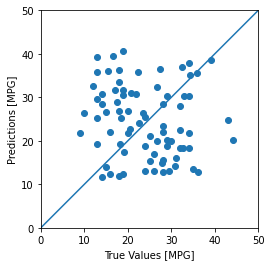

In [36]:
test_predictions = model.predict(test_ds).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


### Show Model Prediction Output

In [37]:
model_pred_outputs = {
    "pred": test_predictions,
    "actual_value": test_labels,
}
model_output_df = pd.DataFrame(model_pred_outputs)

In [38]:
model_output_df.head()

,pred,actual_value
0,14.070079,15.0
1,26.321848,10.0
2,21.858229,9.0
3,15.326762,25.0
4,12.397350,19.0


## 2. Model Evaluation 

### Preparing Regression Output for Binary Scoring Model Evaluation

- Create binary label for mileage prediction over 25 miles per gallon
    - 0 = Not Fuel Efficient, < 25 MPG
    - 1 = Fuel Efficient >= 25 MPG

In [39]:
# Convert Regression Output to binary classification output
model_output_df.head()

,pred,actual_value
0,14.070079,15.0
1,26.321848,10.0
2,21.858229,9.0
3,15.326762,25.0
4,12.397350,19.0


In [40]:
def convert_to_binary(df, pred_field, actual_field):
    df['score'] = df[pred_field].apply(lambda x: 1 if x>=25 else 0 )
    df['label_value'] = df[actual_field].apply(lambda x: 1 if x>=25 else 0)
    return df

In [41]:
binary_df = convert_to_binary(model_output_df, 'pred', 'actual_value')
binary_df.head()

,pred,actual_value,score,label_value
0,14.070079,15.0,0,0
1,26.321848,10.0,1,0
2,21.858229,9.0,0,0
3,15.326762,25.0,0,1
4,12.397350,19.0,0,0


### Classification Common Model Evaluation Metrics

In [42]:
from sklearn.metrics import brier_score_loss, accuracy_score, f1_score, classification_report, roc_auc_score, roc_curve

In [43]:
print(classification_report(binary_df['label_value'], binary_df['score']))

              precision    recall  f1-score   support

           0       0.38      0.37      0.37        41
           1       0.32      0.32      0.32        37

    accuracy                           0.35        78
   macro avg       0.35      0.35      0.35        78
weighted avg       0.35      0.35      0.35        78



In [44]:
#F1
f1_score(binary_df['label_value'], binary_df['score'], average='weighted')

0.34647673314339983

In [45]:
#AUC - area under the ROC curve
roc_auc_score(binary_df['label_value'], binary_df['score'])

0.34508899143045485

### Brier Score

In [46]:
random_predictions = np.random.random((100))
random_predictions

array([4.01624691e-01, 4.36992398e-01, 2.80045957e-02, 1.93521454e-01,
       9.58589659e-01, 4.68973314e-01, 8.98265975e-01, 2.35431784e-01,
       2.34791539e-01, 2.16673154e-02, 6.69589102e-01, 2.09052046e-01,
       6.59760240e-01, 5.54871758e-01, 1.24272987e-01, 9.27902331e-01,
       9.12174112e-01, 6.21412418e-01, 1.92238008e-01, 1.16715283e-02,
       6.30595690e-01, 2.54114506e-01, 7.49261602e-01, 5.51748117e-01,
       2.83383983e-01, 5.08161796e-01, 8.70139645e-01, 1.97341500e-01,
       2.82622569e-01, 4.15462262e-01, 2.36080940e-01, 4.29262448e-01,
       5.58631598e-01, 2.58159351e-01, 6.69608819e-01, 4.21501074e-01,
       4.15457009e-01, 1.95135963e-01, 8.57112052e-01, 2.14886367e-01,
       4.01645771e-01, 9.04554646e-01, 3.09117063e-02, 7.25879837e-01,
       4.36304676e-01, 3.64381474e-01, 2.07432778e-01, 8.45982292e-01,
       5.52623414e-01, 6.24201245e-01, 5.28436356e-01, 1.15006058e-01,
       2.60130800e-01, 8.58440042e-01, 9.85763946e-01, 1.85141241e-01,
      

In [47]:
random_labels = np.random.choice([0, 1], 100)
random_labels

array([0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0])

- Convert probability to binary predictions

In [48]:
probability_prediction_df = pd.DataFrame({"prob_prediction": random_predictions,
                "binary_prediction": np.array([ 1 if abs(x)>=0.5 else 0 for x in random_predictions], dtype=int),
                                "label": random_labels})

In [49]:
probability_prediction_df.head()

,prob_prediction,binary_prediction,label
0,0.401625,0,0
1,0.436992,0,0
2,0.028005,0,1
3,0.193521,0,0
4,0.958590,1,1


In [50]:
y_true = probability_prediction_df['label'].values 
y_pred = probability_prediction_df['binary_prediction'].values

In [51]:
acc = accuracy_score(y_true, y_pred)
print(acc)

0.48


In [52]:
bs_loss = brier_score_loss(y_true, probability_prediction_df['prob_prediction'])
print(bs_loss)

0.35763331289743056


### Misclassified

In [53]:
missclassified_df = probability_prediction_df[probability_prediction_df['binary_prediction']!=probability_prediction_df['label']]

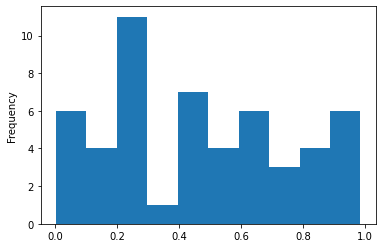

In [54]:
missclassified_df['prob_prediction'].plot(kind='hist')

## 3. Demographic Group Bias Analysis

- Select groups to analyze
- Prepare data 
- Analyze groups


### Select groups to analyze
- Selected 'origin' field which gives the country of origin for the car.

In [55]:
#combine binary df with original test df, order was not shuffled so can do

In [56]:
merged_binary_df = binary_df.assign(origin = test_data['Origin'].values)

In [57]:
merged_binary_df.head()

,pred,actual_value,score,label_value,origin
0,14.070079,15.0,0,0,USA
1,26.321848,10.0,1,0,USA
2,21.858229,9.0,0,0,USA
3,15.326762,25.0,0,1,Japan
4,12.397350,19.0,0,0,USA


### Prepare Data

In [58]:
# Aequitas
from aequitas.preprocessing import preprocess_input_df
from aequitas.group import Group
from aequitas.plotting import Plot
from aequitas.bias import Bias
from aequitas.fairness import Fairness

ModuleNotFoundError: ignored

In [ ]:
ae_df, _ = preprocess_input_df(merged_binary_df)
g = Group()
xtab, _ = g.get_crosstabs(ae_df)
absolute_metrics = g.list_absolute_metrics(xtab)
clean_xtab = xtab.fillna(-1)
aqp = Plot()
b = Bias()

### Analyze Groups

In [ ]:
tpr = aqp.plot_group_metric(clean_xtab, 'tpr', min_group_size=0.05)

In [ ]:
fpr = aqp.plot_group_metric(clean_xtab, 'fpr', min_group_size=0.05)

In [ ]:
tnr = aqp.plot_group_metric(clean_xtab, 'tnr', min_group_size=0.05)

In [ ]:
# Bias Report - http://aequitas.dssg.io/audit/eg1cp7ku/adult_rf_binary/

## 4. Train Uncertainty Estimation Model with TF Probability

### Instructions
- Using MPG model from earlier, create uncertainty estimation model with TF Probability.
- In particular, we will focus on building a model that accounts for Aleatoric Uncertainty.

In [ ]:
import tensorflow_probability as tfp

### Aleatoric Uncertainty
- Known Unknowns
- 2 Main Changes to our network 
    - Add a second unit to the last dense layer before passing it to Tensorflow Probability layer to model for the predictor y and the heteroscedasticity or unequal scattering of data
    - DistributionLambda distribution mean and std
- DistributionLambda is a special Keras layer that uses a Python lambda to construct a distribution based on the layer inputs and the output of the final layer of the model is passed into the loss function. Lastly. this model will return a distribution for both mean and standard deviation.

In [ ]:
train_label_stats = train_labels.describe()
train_label_stats

In [ ]:
def build_seq_prob_model(feature_layer):
    model = tf.keras.Sequential([
        feature_layer,
        tf.keras.layers.Dense(150, activation='relu'),
        tf.keras.layers.Dense(75, activation='relu'),
        tf.keras.layers.Dense(1 + 1),
        tfp.layers.DistributionLambda(  
            lambda t:tfp.distributions.Normal(
                loc=t[..., :1],
                scale=1e-3 + tf.math.softplus(0.1 * t[...,1:])

            )
         )
  
        
        
    ])
    return model

def build_prob_model(train_ds,   feature_layer,  epochs=5, loss_metric='mse'):
    model = build_seq_prob_model(feature_layer)
    negloglik = lambda y, rv_y: -rv_y.log_prob(y)
    loss = negloglik
    model.compile(tf.optimizers.Adam(learning_rate=0.05), loss=loss, metrics=[loss_metric])
    history = model.fit(train_ds, 
                        epochs=epochs)
    return model, history

### Train Probability Model

In [ ]:
prob_model, history = build_prob_model(train_ds, dense_feature_layer,  epochs=500)

### Extract Mean and Standard Deviation Output

In [ ]:
feature_column_list = categorical_feature_list + numerical_feature_list
x_tst = dict(test_data[feature_column_list])
yhat = prob_model(x_tst)
prob_preds = prob_model.predict(test_ds)
m = yhat.mean()
s = yhat.stddev()

In [ ]:
m[0:10]

In [ ]:
s[0:10]

In [ ]:
prob_outputs = {
    "pred": prob_preds.flatten(),
    "actual_value": test_data['MPG'].values,
    "pred_mean": m.numpy().flatten(),
    "pred_std": s.numpy().flatten()
}
prob_output_df = pd.DataFrame(prob_outputs)

In [ ]:
prob_output_df.head()

In [ ]:
a = plt.axes(aspect='equal')
plt.scatter(test_labels, m.numpy().flatten())
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


## 5. Model Interpretability with Shapley Values

- Using Open Source Library Shap - https://github.com/slundberg/shap
- Developed by Su-In Lee's lab at the University of Washington, and Microsoft Research

In [ ]:
# adapted from https://github.com/kweinmeister/notebooks/blob/master/tensorflow-shap-college-debt.ipynb
# https://towardsdatascience.com/understand-how-your-tensorflow-model-is-making-predictions-d0b3c7e88500

In [ ]:
import shap
shap.initjs()

### Train Model without Dense Features

In [ ]:
def build_shap_model( num_features):
    model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=[num_features]),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [ ]:
shap_num_features = len( numerical_feature_list)
shap_feature_columns =  tf_numerical_feature_list
#shap_feature_layer = tf.keras.layers.DenseFeatures(shap_feature_columns)
shap_model = build_shap_model( shap_num_features)

In [ ]:
EPOCHS = 1000
early_stop = tf.keras.callbacks.EarlyStopping(monitor='mse', patience=10)     
shap_history = shap_model.fit( normed_train_data, train_labels,  callbacks=[early_stop], epochs=EPOCHS,  verbose=1)

### Use KMeans to Summarize Dataset

In [ ]:
df_train_normed_summary = shap.kmeans(normed_train_data.values, 25)


In [ ]:
# Instantiate an explainer with the model predictions and training data summary
explainer = shap.KernelExplainer(shap_model.predict, df_train_normed_summary)

In [ ]:
# may need to install ipywidgets to see status visualization
'''
pip install ipywidgets
jupyter nbextension enable --py widgetsnbextension
'''

In [ ]:
# Extract Shapley values from the explainer
shap_values = explainer.shap_values(normed_train_data.values)

In [ ]:
# Summarize the Shapley values in a plot
shap.summary_plot(shap_values[0], normed_train_data)

In [ ]:
INSTANCE_NUM = 0
shap.force_plot(explainer.expected_value[0], shap_values[0][INSTANCE_NUM], normed_train_data.iloc[INSTANCE_NUM,:])

In [ ]:
# Plot the SHAP values for multiple instances
NUM_ROWS = 10
shap.force_plot(explainer.expected_value[0], shap_values[0][0:NUM_ROWS], normed_train_data.iloc[0:NUM_ROWS])